In [25]:
# OANDA
import configparser
import pandas as pd
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import datetime
from datetime import datetime, timedelta
import pytz
import matplotlib as mpl
import matplotlib.pyplot as plt

In [26]:
# 設定
config = configparser.ConfigParser()
config.read('config_v1.txt') 
account_id = config['oanda']['account_id']
api_key = config['oanda']['api_key']

In [98]:
instrument = "USD_JPY"
params = {"count": 50, "granularity": "M30"}

In [99]:
# APIへ接続
api = API(access_token=api_key)
r = instruments.InstrumentsCandles(instrument=instrument, params=params)
api.request(r)
# dataとしてリストへ変換
data = []
for raw in r.response['candles']:
    data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

,volume,open,high,low,close
time,,,,,
2020-06-05 18:30:00,1245,109.621,109.658,109.607,109.610
2020-06-05 19:00:00,814,109.608,109.638,109.578,109.615
2020-06-05 19:30:00,778,109.614,109.657,109.594,109.644
2020-06-05 20:00:00,444,109.646,109.675,109.602,109.614
2020-06-05 20:30:00,281,109.612,109.629,109.578,109.590


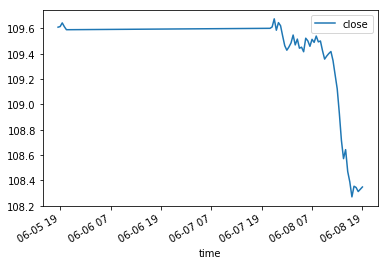

In [126]:
# リストからデータフレームへ変換
df = pd.DataFrame(data)
for i in range(4):
    df[i+2] = df[i+2].astype('float')
df.columns = ['time', 'volume', 'open', 'high', 'low', 'close']
df = df.set_index('time')
# date型を綺麗にする
df.index = pd.to_datetime(df.index)
df.head()
# df.iloc[:,1:5].plot()
df.plot(y=df.columns[4])
df.head()

In [140]:
#　移動平均線
res = ""
print(df['close'][-5:])

sum = 0
for i in range(5):
    sum += df['close'][-i]
red_ave = sum/5

sum = 0
for i in range(13):
    sum += df['close'][-i]
yellow_ave = sum/13

sum=0
for i in range(21):
    sum += df['close'][-i]
blue_ave = sum/21
print(red_ave,yellow_ave,blue_ave)
if (red_ave>yellow_ave>blue_ave):
    res = "移動平均線が理想的に上昇"
elif (red_ave<yellow_ave<blue_ave):
    res = "移動平均線が理想的に下降"
print(res)

time
2020-06-08 17:00:00    108.354
2020-06-08 17:30:00    108.344
2020-06-08 18:00:00    108.312
2020-06-08 18:30:00    108.330
2020-06-08 19:00:00    108.348
Name: close, dtype: float64
108.58879999999999 108.5606923076923 108.85600000000001



移動平均線
赤　5本
黄色　13本
青　21本

## LINEを送る

In [24]:
from functions.line_notify_bot import LINENotifyBot

bot = LINENotifyBot(access_token='iCOQf3nXJkDKxU5pkOf6Mn4sT3f6DoPGbiZ9AAp0Ry6')
bot.send(
    message='Write Your Message',
    )

messageに通貨ペアをアナウンス

In [18]:
message = 'My Message'
# image = 'test.png'  # png or jpg
payload = {'message': message}
# files = {'imageFile': open(image, 'rb')}
# r = requests.post(url, headers=headers, params=payload, files=files,)
r = requests.post(url, headers=headers, params=payload)

## メールを送る

In [6]:
# smtp_host = 'smtp.gmail.com'
# smtp_port = 465
# username = 'saaaxx.y0717@gmail.com'
# password = 'Ko1116q4MD'
# from_address = 'saaaxx.y0717@gmail.com'
# to_address = 'saaaxx.y0717@gmail.com'
# subject = 'test subject'
# body = 'test body'
# message = ("From: %s\r\nTo: %s\r\nSubject: %s\r\n\r\n%s" % (from_address, to_address, subject, body))

# smtp = smtplib.SMTP_SSL(smtp_host, smtp_port)
# smtp.login(username, password)
# result = smtp.sendmail(from_address, to_address, message)
# print(result)

In [12]:
#メール
import smtplib
import os
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import base64
from email.mime.text import MIMEText
from apiclient import errors


In [13]:
# Gmail APIのスコープを設定
SCOPES = ['https://www.googleapis.com/auth/gmail.send']
# メール本文の作成
def create_message(sender, to, subject, message_text):
    message = MIMEText(message_text)
    message['to'] = to
    message['from'] = sender
    message['subject'] = subject
    encode_message = base64.urlsafe_b64encode(message.as_bytes())
    return {'raw': encode_message.decode()}

# メール送信の実行
def send_message(service, user_id, message):
    try:
        message = (service.users().messages().send(userId=user_id, body=message)
                   .execute())
        print('Message Id: %s' % message['id'])
        return message
    except errors.HttpError as error:
        print('An error occurred: %s' % error)
        

def main():
    # 5. アクセストークンの取得
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('../client_secret_226080186606-qrskl6haa432e78q4u39so90nf9ue72n.apps.googleusercontent.com.json', SCOPES)
            creds = flow.run_local_server()
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)
    service = build('gmail', 'v1', credentials=creds)
    # 6. メール本文の作成
    sender = 'saaaxx.y0717@gmail.com'
    to = 'saaaxx.y0717@gmail.com'
    subject = 'メール送信自動化テスト'
    message_text = 'メール送信の自動化テストをしています。'
    message = create_message(sender, to, subject, message_text)
    # 7. Gmail APIを呼び出してメール送信
    send_message(service, 'me', message)



In [15]:
main()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=226080186606-qrskl6haa432e78q4u39so90nf9ue72n.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.send&state=uxptBRXYuxHrxFuTKD8hGE4KUdOTga&access_type=offline


KeyboardInterrupt: 